In [1]:
# import library
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random

import pymoo
from pymoo.core.problem import Problem

import joblib


import pandas as pd
import random
import math
import os

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.optimize import minimize
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting


import csv
import os



In [2]:
# import ML model

import time
date = time.strftime("%y%m%d")
import os
date = 251112
print("start")

model_names = [
    f"Lmt_{date}",
    f"Llt_{date}",
    f"copperloss_Tx_{date}",
    f"copperloss_Rx1_{date}",
    f"copperloss_Rx2_{date}",
    f"coreloss_{date}",
    f"magnetizing_copperloss_Tx_{date}",
    f"magnetizing_copperloss_Rx1_{date}",
    f"magnetizing_copperloss_Rx2_{date}",
    f"B_left_{date}",
    f"B_center_{date}",
    f"B_top_left_{date}"
]

model_labels = [
    "Lmt",
    "Llt", 
    "copperloss_Tx",
    "copperloss_Rx1",
    "copperloss_Rx2",
    "coreloss",
    "magnetizing_copperloss_Tx",
    "magnetizing_copperloss_Rx1",
    "magnetizing_copperloss_Rx2",
    "B_left",
    "B_center",
    "B_top_left"
]

# dict에 담아서 관리
models = {}
for name, label in zip(model_names, model_labels):
    model_path = f"model/{name}.pkl"
    
    # 파일 존재 여부 확인
    if not os.path.exists(model_path):
        print(f"모델 파일이 존재하지 않습니다: {model_path}")
        continue
        
    try:
        print(f"Loading model: {name}")
        models[label] = joblib.load(model_path)
    except Exception as e:
        print(f"모델 로딩 중 에러 발생: {name}")
        print(f"에러 메시지: {str(e)}")

start
Loading model: Lmt_251112
Loading model: Llt_251112
Loading model: copperloss_Tx_251112
Loading model: copperloss_Rx1_251112
Loading model: copperloss_Rx2_251112
Loading model: coreloss_251112
Loading model: magnetizing_copperloss_Tx_251112
Loading model: magnetizing_copperloss_Rx1_251112
Loading model: magnetizing_copperloss_Rx2_251112
Loading model: B_left_251112
Loading model: B_center_251112
Loading model: B_top_left_251112


In [3]:
import numpy as np, random, math

SCALE  = np.array([5, 50, 1, 0.1, 0.1, 0.1, 0.01,
                   1, 1, 0.1, 0.1, 0.01, 0.1, 0.035, 
                   0.1, 0.1, 0.01, 0.01, 0.1, 0.1, 
                   0.01, 1], dtype=float)
OFFSET = np.array([0, 100, 0, 0, 0, 0, 
                   0, 0, 0, 0, 0, 0, 
                   0, 0, 0, 0, 0, 0,
                   0, 0, 0, 0],    dtype=float)

def decode_vars(X_raw: np.ndarray) -> np.ndarray:
    """
    정수형 설계변수 → 실제 물리 단위로 변환.
    X_raw : shape (n, 14) 또는 (14,)
    """
    X = np.atleast_2d(X_raw).astype(float)
    return X * SCALE + OFFSET 

def pre_processing_data_copper(X_raw) :
    # "w1","g1","g2","l1_leg","l1_top","l2","h1","w1_ratio","l1_center","ratio","pri_turns","width_ratio","pri_width","pri_height","pri_space_x","pri_x","pri_preg","sec_width","sec_x","sec_space_y",
    #                                "sec_y","sec_preg","sec_height","sec_space_x","pri_space_y","pri_y"
    X = decode_vars(X_raw)
    (freq,input_voltage,w1,l1_leg,l1_top,l2,h1,l1_center,Tx_turns,Tx_space_x,
     Tx_space_y,Tx_preg,Rx_width,Rx_height,Rx_space_x,Rx_space_y,Rx_preg,
     g2,Tx_layer_space_x,Tx_layer_space_y,wire_diameter,strand_number) = X.T
    
    Tx_width  = (wire_diameter**2 * strand_number * 2)**0.5
    Tx_height = Tx_width

    new_data = np.column_stack((freq, w1, l1_leg, l1_top, l2, h1, l1_center, Tx_turns, Tx_width, Tx_height, 
                                Tx_space_x, Tx_space_y, Tx_preg, Rx_width, Rx_height, Rx_space_x, Rx_space_y,
                                Rx_preg, g2, Tx_layer_space_x, Tx_layer_space_y,wire_diameter,strand_number
                                ))
    
    return new_data


def pre_processing_data_core(X_raw,Tx_current,magnetizing_current) :
    # "w1","g1","g2","l1_leg","l1_top","l2","h1","w1_ratio","l1_center","ratio","pri_turns","width_ratio","pri_width","pri_height","pri_space_x","pri_x","pri_preg","sec_width","sec_x","sec_space_y",
    #                                "sec_y","sec_preg","sec_height","sec_space_x","pri_space_y","pri_y"
    X = decode_vars(X_raw)
    (freq,input_voltage,w1,l1_leg,l1_top,l2,h1,l1_center,Tx_turns,Tx_space_x,
     Tx_space_y,Tx_preg,Rx_width,Rx_height,Rx_space_x,Rx_space_y,Rx_preg,
     g2,Tx_layer_space_x,Tx_layer_space_y,wire_diameter,strand_number) = X.T

    Tx_width  = (wire_diameter**2 * strand_number * 2)**0.5
    Tx_height = Tx_width

    new_data = np.column_stack((freq, w1, l1_leg, l1_top, l2, h1, l1_center, Tx_turns, Tx_width, Tx_height, 
                                Tx_space_x, Tx_space_y, Tx_preg, Rx_width, Rx_height, Rx_space_x, Rx_space_y,
                                Rx_preg, g2, Tx_layer_space_x, Tx_layer_space_y,wire_diameter,strand_number,
                                magnetizing_current))
    
    return new_data

def compute_area(X_raw):
    X = decode_vars(X_raw)
    # ── 0. 입력 분해 (2D 배열 X) ────────────────────────────
    (freq,input_voltage,w1,l1_leg,l1_top,l2,h1,l1_center,Tx_turns,Tx_space_x,
     Tx_space_y,Tx_preg,Rx_width,Rx_height,Rx_space_x,Rx_space_y,Rx_preg,
     g2,Tx_layer_space_x,Tx_layer_space_y,wire_diameter,strand_number) = X.T

    Tx_width  = (wire_diameter**2 * strand_number * 2)**0.5
    Tx_height = Tx_width

    # volume
    Area = (l1_leg + l2 + l1_center/2)*2 * (w1+Tx_layer_space_x*4+Tx_width*5+Tx_space_x+Rx_space_x+Rx_width)
    height = l1_top*2 + h1
    Volume = Area * height
    
    Tx = Tx_width * 5 + Tx_layer_space_y * 4 + Tx_space_y
    Rx = Rx_width + Rx_space_y
    max_length = l2 - (Tx+Rx)
    gap = h1 - g2

    coil_height = Tx_height*2 + Tx_preg + Rx_height*2 + Rx_preg*2
    hh = h1  - coil_height       
    Tx_Rx = Tx_preg/2 + Rx_preg
    


    return Area, height, max_length, Tx_Rx, hh, gap, Volume


In [4]:
# "w1","l1_leg","l1_top","l2","h1","l1_center","Tx_turns","Tx_width","Tx_height","Tx_space_x","Tx_space_y",
# "Tx_preg","Rx_width","Rx_height","Rx_space_x","Rx_space_y","Rx_preg",
# "g2","Tx_layer_space_x","Tx_layer_space_y","wire_diameter","strand_number"

vars1 = { # under, upper, resolution
    "freq_range" : [1,80,1,0],#*5
    "input_voltage_range" : [1,8,1,0],#*50 + 100

    "w1_range": [20, 200, 1, 0],
    "l1_leg_range": [20, 150, 1, 0], # *0.1
    "l1_top_range": [5, 20, 1, 0], # *0.1
    "l2_range": [50, 300, 1, 0], # *0.1

    "h1_range": [10, 300, 1, 0], # *0.01 
    
    "l1_center_range": [1, 25, 1, 0],

    "Tx_turns_range" : [2,20,1,0],
    "Tx_space_x_range": [1, 50, 1, 0],# *0.1 
    "Tx_space_y_range": [1, 50, 1, 0],# *0.1
    "Tx_preg_range": [5, 30, 1, 0],# *0.01

    "Rx_width_range": [40, 200, 1, 0], # *0.1
    "Rx_height_range": [1, 5, 1, 0],# *0.035
    "Rx_space_x_range": [1, 50, 1, 0],# *0.1
    "Rx_space_y_range": [1, 50, 1, 0],# *0.1
    "Rx_preg_range": [5, 30, 1, 0],# *0.01

    "g2_range" : [10,300,1,0], #*0.01

    "Tx_layer_space_x_range": [2, 50, 1, 0],# *0.1
    "Tx_layer_space_y_range": [2, 50, 1, 0],# *0.1

    "wire_diameter_range": [5, 8, 1, 0],# *0.01
    "strand_number_range": [7, 100, 1, 0],


}

class ProblemVariables:
    def __init__(self, var_dict):
        self.var_dict = var_dict
        self.names = list(var_dict.keys())

    def get_num_of_variables(self):
        return len(self.var_dict)

    def get_lower_bounds(self):
        return np.array([v[0] for v in self.var_dict.values()])

    def get_upper_bounds(self):
        return np.array([v[1] for v in self.var_dict.values()])

class MyProblem(Problem) :

    def __init__(self, problem_vars):
        self.vars = problem_vars
        super().__init__(n_var=self.vars.get_num_of_variables(),     #number of inputs
                    n_obj=2,     #number of outputs
                    n_constr=11,  #nubmer of constraints
                    xl=np.array(self.vars.get_lower_bounds()), #input lower bounds
                    xu=np.array(self.vars.get_upper_bounds()), #input upper bounds
                    type_var = int)
 
    #[N1, N2, freq, per, w1, l1, l2, h1, l1_leg, l1_top, g1, g2, coil_width_inner_ratio, coil_width_outer_ratio, coil_width_x_ratio, coil_height, space_height,
    # space_inner_ratio, space_outer_ratio, space_x_ratio, move_z, ratio]
    
    def _evaluate(self, X, out, *args, **kwargs) :

        Lmt_data = pre_processing_data_copper(X)

        tx_val = 4*math.sqrt(2)
        rx_val = 11*math.sqrt(2)
        n = Lmt_data.shape[0]

        # 스칼라 → (n,1) 컬럼으로 확장
        tx_col = np.full((n, 1), tx_val, dtype=Lmt_data.dtype)
        rx_col = np.full((n, 1), rx_val, dtype=Lmt_data.dtype)

        # 열 붙이기
        copper_data = np.hstack((Lmt_data, tx_col, rx_col))


        
        copperloss_Tx = models["copperloss_Tx"].predict(copper_data) 
        copperloss_Rx1 = models["copperloss_Rx1"].predict(copper_data)
        copperloss_Rx2 = models["copperloss_Rx2"].predict(copper_data)
        
        Lmt = models["Lmt"].predict(copper_data)
        Llt = models["Llt"].predict(copper_data)

        freq_one = X[:,0]
        freq = freq_one * 5

        input_voltage_one = X[:,1]
        input_voltage = input_voltage_one*50 +100

        magnetizing_current = input_voltage*math.sqrt(2)/2/math.pi/freq/10**3/Lmt/10**(-6)/2 # 제일 마지막 /2 시뮬 돌릴때 잘못넣음 시뮬은 수정해서 다음번에 NSGA 복사할때 /2 제거해야함

        core_data = pre_processing_data_core(X,tx_col,magnetizing_current)

        coreloss = models["coreloss"].predict(core_data)
        magnetizing_copperloss_Tx = models["magnetizing_copperloss_Tx"].predict(core_data)
        magnetizing_copperloss_Rx1 = models["magnetizing_copperloss_Rx1"].predict(core_data)
        magnetizing_copperloss_Rx2 = models["magnetizing_copperloss_Rx2"].predict(core_data)


        Area, height, max_length, Tx_Rx, hh, gap, Volume = compute_area(X)
        # Core volume
 

        #Total loss
        total_loss = copperloss_Tx + copperloss_Rx1 + copperloss_Rx2 + coreloss + magnetizing_copperloss_Tx + magnetizing_copperloss_Rx1 + magnetizing_copperloss_Rx2

        #calculate B field

        B_center = models["B_center"].predict(core_data)
        B_left = models["B_left"].predict(core_data)
        B_top_left = models["B_top_left"].predict(core_data)



        gLmt = (Lmt - 67)*(Lmt - 73)
        gh = (height - 4.5)*(height-5)

        gB_center =  (B_center-0.3)
        gB_left =  (B_left-0.3)
        gB_top_left =  (B_top_left-0.3)


        gmax_length = -(max_length-0.00001)
        ghh = -(hh - 0.00001)
        ggap = -(gap - 0.00001)
        gTx_Rx = -(Tx_Rx - 0.0004)
        ginput_voltage = (input_voltage - 380)*(input_voltage - 420)
        gfreq = (freq - 100)*(freq - 150)
        # print(f"Tx:{Tx}")
        # print(f"B_left:{B_left}")
        # print(f"B_top_left:{B_top_left}")
    
        



        out["F"] = np.column_stack([Volume,total_loss]) # "Minimize" values (volume, coreloss)
        #out["G"] = np.column_stack([gB, gxgap, gygap1, gygap2, gAT, gAR, gBT, gBR])
        out["G"] = np.column_stack([gLmt,gh,gB_center,ghh,gmax_length,ggap,gB_left,gB_top_left,gTx_Rx,ginput_voltage,gfreq])
        out["magnetizing_current"]   = magnetizing_current
        out["input_voltage"]          = input_voltage
        out["copper_data"]          = copper_data 
        out["Lmt_data"]             = copper_data
        out["core_data"]           = core_data
        out["Area"]              = Area
        out["Volume"]            = Volume

my_vars = ProblemVariables(vars1)

def run_nsga2(seed, problem):
    np.random.seed(seed)
    random.seed(seed)

    algorithm = NSGA2(
        pop_size=MU,
        sampling=IntegerRandomSampling(),
        crossover=SBX(prob=CXPB, eta=15, repair=RoundingRepair()),
        mutation=PM(eta=20, repair=RoundingRepair()),
        eliminate_duplicates=True
    )

    return minimize(
        problem= problem,
        algorithm=algorithm,
        termination=('n_gen', NGEN),
        seed=seed,
        verbose=True
    )

MU, NGEN = 100, 400
CXPB, MUTPB = 0.7, 0.3
NUM_ITRS = 5
feature_names = ["freq","w1","l1_leg","l1_top","l2","h1","l1_center","Tx_turns","Tx_width",
                 "Tx_height","Tx_space_x","Tx_space_y","Tx_preg",
                 "Rx_width","Rx_height","Rx_space_x","Rx_space_y","Rx_preg",
                 "g2","Tx_layer_space_x","Tx_layer_space_y",
                 "wire_diameter","strand_number","Tx_current","Rx_current"] 
                
def build_df_from_result(res):
    """pymoo 결과(res) → 파레토 해 집합 DataFrame (벡터화 버전)"""
    # 1) Pareto set (X) 전체를 2-D 로 확보

    # 2) pre-processing (벡터화)
    magnetizing_current = res.pop.get("magnetizing_current")
    input_voltage    = res.pop.get("input_voltage")
    copper_data      = res.pop.get("copper_data")          # shape (n, p)    # shape (n, p+1)
    core_data      = res.pop.get("core_data")
    Lmt_data      = res.pop.get("Lmt_data")
    X_design      = res.X.astype(int)                # 원본 정수 설계벡터
    n             = len(res.pop)
    Area          = res.pop.get("Area")
    Volume        = res.pop.get("Volume")



    # 3) ML 모델 일괄 예측
    copperloss_Tx = models["copperloss_Tx"].predict(copper_data)      # (n,)
    copperloss_Rx1 = models["copperloss_Rx1"].predict(copper_data)
    copperloss_Rx2 = models["copperloss_Rx2"].predict(copper_data)
    Lmt          = models["Lmt"].predict(Lmt_data)
    Llt          = models["Llt"].predict(copper_data)

    magnetizing_copperloss_Tx = models["magnetizing_copperloss_Tx"].predict(core_data)
    magnetizing_copperloss_Rx1 = models["magnetizing_copperloss_Rx1"].predict(core_data)
    magnetizing_copperloss_Rx2 = models["magnetizing_copperloss_Rx2"].predict(core_data)

    coreloss      = models["coreloss"].predict(core_data)
    B_center      = models["B_center"].predict(core_data)
    B_top_left    = models["B_top_left"].predict(core_data)
    B_left        = models["B_left"].predict(core_data)


    total_loss    = copperloss_Tx + copperloss_Rx1 + copperloss_Rx2 + coreloss + magnetizing_copperloss_Tx + magnetizing_copperloss_Rx1 + magnetizing_copperloss_Rx2

    
    # 5) DataFrame assemble
    df = pd.DataFrame(copper_data, columns=feature_names)
    df = df.assign(
        magnetizing_current = magnetizing_current,
        input_voltage       = input_voltage,
        Lmt                 = Lmt,
        Llt                 = Llt,
        copperloss_Tx       = copperloss_Tx,
        copperloss_Rx1       = copperloss_Rx1,
        copperloss_Rx2       = copperloss_Rx2,
        coreloss            = coreloss,
        magnetizing_copperloss_Tx = magnetizing_copperloss_Tx,
        magnetizing_copperloss_Rx1 = magnetizing_copperloss_Rx1,
        magnetizing_copperloss_Rx2 = magnetizing_copperloss_Rx2,
        total_loss          = total_loss,
        B_center            = B_center,
        B_left              = B_left,
        Area                = Area,
        Volume              = Volume
        # 필요 시
    )

    return df
    
pareto_file = 'pareto_front.csv'
loop_counter_file = 'loop_counter.txt'
best_values_file = 'best_values.csv'

import time
problem_instance = MyProblem(my_vars)
all_results = []

pareto_file = 'pareto_front.csv'
loop_counter_file = 'loop_counter.txt'
best_values_file = 'best_values.csv'

for itr in range(NUM_ITRS):
    print(f"Running NSGA-II {itr+1} / {NUM_ITRS}")
    seed = np.random.randint(0, 1000000)
    
    try:
        res = run_nsga2(seed, problem_instance)
        df = build_df_from_result(res)

        if df is not None:
            print(f"NSGA-II 완료: {len(df)} 개의 해 발견")

            
            # 2. 파일 락 획득 및 읽기
            print("파일 락 획득 시도...")
            while True:
                try:
                    with open(pareto_file, 'a+') as f_pareto, \
                         open(best_values_file, 'a+') as f_best, \
                         open(loop_counter_file, 'a+') as f_counter:
                        

                        # 파일 읽기
                        f_pareto.seek(0)
                        f_best.seek(0)
                        f_counter.seek(0)
                        
                        current_pareto = pd.read_csv(f_pareto) if os.path.getsize(pareto_file) > 0 else pd.DataFrame()
                        current_best_values = pd.read_csv(f_best) if os.path.getsize(best_values_file) > 0 else pd.DataFrame(columns=['iteration', 'max_Volume', 'min_loss'])
                        current_loop_counter = int(f_counter.read().strip()) if os.path.getsize(loop_counter_file) > 0 else 0
                        
                        print(f"현재 파레토 크기: {len(current_pareto)} 행")
                        print(f"현재 best_values 크기: {len(current_best_values)} 행")
                        print(f"현재 루프 카운터: {current_loop_counter}")
                        
                        # 3. 데이터 처리 (빠른 처리)
                        print("데이터 처리 시작...")
                        df_current = pd.concat([df, current_pareto], ignore_index=True)
                        print(len(df_current))
                        F = df_current[["Volume", "total_loss"]].to_numpy()
                        
                        nds = NonDominatedSorting().do(F, only_non_dominated_front=True)
                        df_pareto = df_current.iloc[nds].copy()
                        df_pareto["total_loss"] = F[nds, 1]  # 효율 부호 복원
                        df_pareto = df_pareto.sort_values(by="total_loss", ascending=False).reset_index(drop=True)
                        
                        max_loss = df['total_loss'].min()
                        min_Volume = df['Volume'].max()
                        
                        new_loop_counter = current_loop_counter + 1
                        
                        new_row = pd.DataFrame({
                            'iteration': [new_loop_counter],
                            'max_loss': [max_loss],
                            'min_Volume': [min_Volume]
                        })
                        
                        updated_best_values = pd.concat([current_best_values, new_row], ignore_index=True)
                        
                        print(f"논 도미네이티드 소팅 완료: {len(df_pareto)} 행")
                        
                        # 4. 파일 쓰기
                        print("파일 쓰기 시작...")
                        f_pareto.seek(0)
                        f_pareto.truncate()
                        df_pareto.to_csv(f_pareto, index=False)
                        
                        f_best.seek(0)
                        f_best.truncate()
                        updated_best_values.to_csv(f_best, index=False)
                        
                        f_counter.seek(0)
                        f_counter.truncate()
                        f_counter.write(str(new_loop_counter))
                        
                        # 백업 생성 (10회마다)
                        # if new_loop_counter % 10 == 0 or new_loop_counter == 1:
                        if True :
                            backup_file = f'pareto_front_backup_{new_loop_counter}.csv'
                            df_pareto.to_csv(backup_file, index=False)
                            print(f"Backup created: {backup_file}")
                        
                        print(f"Iteration {itr+1} 완료 (Total loops: {new_loop_counter})")
                        print(f"Max loss: {max_loss:.4f}, Min Volume: {min_Volume:.4f}")
                        print("=" * 50)
                        
                        # 락 해제는 with 블록을 나가면서 자동으로 수행됨
                        break
                except BlockingIOError:
                    print("다른 프로세스가 파일을 사용 중입니다. 1초 후 재시도...")
                    time.sleep(1)
                    continue
            
    except Exception as e:
        print(f"Error in iteration {itr+1}: {str(e)}")
        continue

# 최종 결과 출력
if 'df_pareto' in locals():
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    print("Final Pareto front:")
    print(df_pareto)
else:
    print("No valid results found")


Running NSGA-II 1 / 5
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  4.513607E+02 |  1.017893E+05 |             - |             -
     2 |      200 |      1 |  2.652285E+02 |  1.437938E+04 |             - |             -
     3 |      300 |      1 |  1.575517E+01 |  5.443426E+03 |             - |             -
     4 |      400 |      1 |  0.3796100000 |  1.739661E+03 |             - |             -
     5 |      500 |      1 |  0.3796100000 |  7.013069E+02 |             - |             -
     6 |      600 |      1 |  0.3796100000 |  1.959272E+02 |             - |             -
     7 |      700 |      1 |  0.1554728877 |  6.565359E+01 |             - |             -
     8 |      800 |      1 |  0.1554728877 |  2.126871E+01 |             - |             -
     9 |      900 |      1 |  0.1554728877 |  1.359991E+01 |             - |             -
    10 |     1000 |      1 |  0.1554728877 |  7.6496756414 |        

In [5]:
# problem_instance = MyProblem(my_vars)
# run_nsga2(seed, problem_instance)

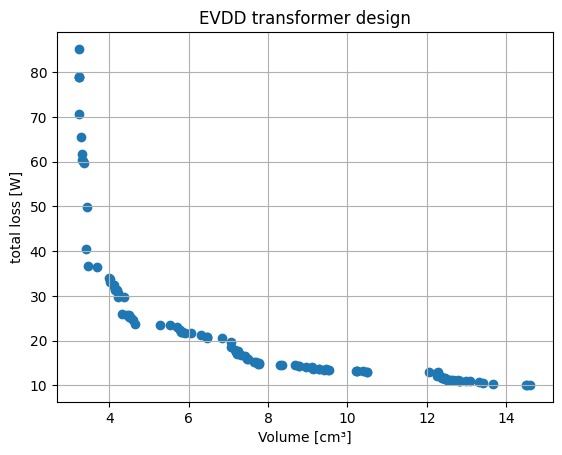

In [8]:
import matplotlib.pyplot as plt

# pymoo 결과 res에서 F를 꺼내 옵니다 (shape = [n_points, 2])
F = df_pareto
# F = final_F

# 1열이 f1, 2열이 f2

plt.figure()

f1_vals = ((F["l1_leg"] + F["l2"] + F["l1_center"]/2)*2) * (F["w1"] + (F["Rx_space_x"]+F["Rx_width"])) * (F["h1"] + F["l1_top"]*2) * 1e-3
f2_vals = F["total_loss"]
plt.scatter(f1_vals, f2_vals)
plt.xlabel('Volume [cm³]') 
plt.ylabel('total loss [W]')
plt.title('EVDD transformer design')
plt.grid(True)
plt.show()

In [9]:
df_pareto

,freq,w1,l1_leg,l1_top,l2,h1,l1_center,Tx_turns,Tx_width,Tx_height,Tx_space_x,Tx_space_y,Tx_preg,Rx_width,Rx_height,Rx_space_x,Rx_space_y,Rx_preg,g2,Tx_layer_space_x,Tx_layer_space_y,wire_diameter,strand_number,Tx_current,Rx_current,magnetizing_current,input_voltage,Lmt,Llt,copperloss_Tx,copperloss_Rx1,copperloss_Rx2,coreloss,magnetizing_copperloss_Tx,magnetizing_copperloss_Rx1,magnetizing_copperloss_Rx2,total_loss,B_center,B_left,Area,Volume
0,150.0,32.0,2.0,1.2,7.0,2.10,2.0,15.0,0.187083,0.187083,0.1,0.1,0.07,4.0,0.140,0.1,1.0,0.22,0.30,0.2,0.2,0.05,7.0,5.656854,15.556349,4.460329,400.0,67.283248,16.361150,32.573491,9.896060,7.928327,5.141066,17.716811,5.870344,6.105141,85.231241,0.171568,0.154931,758.708287,3414.187291
1,150.0,32.0,2.0,1.2,7.0,2.10,2.0,15.0,0.212132,0.212132,0.1,0.1,0.07,4.0,0.140,0.1,1.0,0.22,0.31,0.2,0.2,0.05,9.0,5.656854,15.556349,4.460329,400.0,67.283248,16.387425,28.211332,9.977950,7.928327,5.141066,15.807129,5.870344,6.105141,79.041289,0.160869,0.148119,761.213203,3425.459415
2,150.0,32.0,2.0,1.2,7.0,2.10,2.0,15.0,0.212132,0.212132,0.1,0.1,0.06,4.0,0.140,0.1,1.0,0.22,0.30,0.2,0.2,0.05,9.0,5.656854,15.556349,4.460329,400.0,67.283248,16.387425,28.211332,9.977950,7.928327,5.141066,15.807129,5.870344,6.105141,79.041289,0.160869,0.147612,761.213203,3425.459415
3,150.0,32.0,2.0,1.2,7.0,2.10,2.0,15.0,0.212132,0.212132,0.1,0.1,0.06,4.0,0.140,0.1,1.0,0.22,0.31,0.2,0.2,0.05,9.0,5.656854,15.556349,4.460329,400.0,67.283248,16.387425,28.211332,9.977950,7.928327,5.141066,15.807129,5.870344,6.105141,79.041289,0.160869,0.147612,761.213203,3425.459415
4,150.0,32.0,2.0,1.2,7.0,2.10,2.0,15.0,0.234521,0.234521,0.1,0.1,0.07,4.0,0.140,0.1,0.9,0.22,0.29,0.2,0.2,0.05,11.0,5.656854,15.556349,4.134853,400.0,72.579472,16.944324,24.232907,10.710797,8.134281,4.515658,12.038661,5.577173,5.415492,70.624968,0.158942,0.142080,763.452079,3435.534355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,150.0,71.0,2.0,1.6,12.0,1.43,10.0,6.0,0.406202,0.406202,0.1,0.8,0.08,4.0,0.175,1.2,4.1,0.06,0.76,0.2,0.2,0.05,33.0,5.656854,15.556349,4.133059,400.0,72.610971,5.004601,4.174274,0.968048,0.261516,1.871571,2.779399,0.347824,0.195090,10.597722,0.070995,0.180985,3006.978365,13922.309829
108,150.0,71.0,2.0,1.6,12.9,1.30,10.0,6.0,0.406202,0.406202,0.2,0.8,0.05,5.2,0.140,0.1,4.0,0.07,0.76,0.2,0.2,0.05,33.0,5.656854,15.556349,4.132367,400.0,72.623130,4.323814,3.960492,0.954516,0.256649,1.811051,2.748924,0.397329,0.232786,10.361747,0.073133,0.162865,3157.374182,14208.183820
109,150.0,71.0,2.0,1.7,13.0,1.30,10.0,6.0,0.406202,0.406202,0.4,0.7,0.08,5.1,0.140,1.0,3.9,0.06,0.76,0.2,0.2,0.05,33.0,5.656854,15.556349,4.113466,400.0,72.956829,3.893914,4.016418,0.948580,0.274570,1.595810,2.783575,0.335403,0.177694,10.132051,0.066846,0.192198,3213.240384,15102.229805
110,150.0,71.0,2.0,1.7,13.0,1.30,10.0,6.0,0.406202,0.406202,0.4,0.7,0.08,5.2,0.140,1.0,3.9,0.06,0.76,0.2,0.2,0.05,33.0,5.656854,15.556349,4.113466,400.0,72.956829,3.849338,4.014103,0.948580,0.274101,1.586584,2.783575,0.335208,0.175861,10.118012,0.066766,0.184838,3217.240384,15121.029805


In [10]:
df_pareto.to_csv('pareto_front_final.csv', index=False)